# Driving a transmon qubit in the rotating frame
In this tutorial we show how to drive a transmon qubit using pysqkit and how to extract the fidelity of the desired single-qubit gate. Differently than the simple driving transmon case, we work in the rotating frame. This can be achieved with a simple code adaptation

In [14]:
import numpy as np 
import time
from typing import Callable
import matplotlib.pyplot as plt
from pysqkit.qubits import SimpleTransmon
from pysqkit.drives import microwave_drive, bosonic_drive
from pysqkit.drives.pulses import constant_pulse
from pysqkit.drives.pulse_shapes import gaussian_top
from pysqkit.util.metrics import average_process_fidelity, average_gate_fidelity
from pysqkit.util.phys import temperature_to_thermalenergy
from pysqkit.util.hsbasis import weyl_by_index
import pysqkit.util.transformations as trf
from pysqkit.util.quantum import generalized_rabi_frequency
from pysqkit.solvers import solvkit
from pysqkit.tomography import TomoEnv
import qutip
import matplotlib 
matplotlib.rcParams['mathtext.fontset'] = 'cm'
from IPython.display import display, Latex

A microwave gate for a transmon qubit is based on the following driven Hamiltonian in the rotating frame with reference Hamiltonian $H_{ref} = \hbar \omega_T \hat{b}^{\dagger}\hat{b}$

$$H = H^{(0)}_T  + H_{drive},$$

$$H^{(0)}_T =   \hbar \frac{\delta_T}{2} \hat{b}^{\dagger} \hat{b}^{\dagger}\hat{b} \hat{b},$$


$$\frac{H_{drive}}{h} = \varepsilon_T \cos(2\pi f_d t) \hat{n}_T(t).$$

The (approximate) charge operator for the transmon in terms of annihilation and creation operators reads

$$
\hat{n}_T(t) = i \biggl( \frac{E_J}{32 |\delta_T |} \biggr)^{1/4} (b^{\dagger}e^{i \omega_T t} - b e^{-i \omega_T t}),
$$
where 
$$
E_J = \hbar \biggl(\frac{\omega_T - \delta_T}{8 | \delta_T |} \biggr)^2.
$$
Let us introduce the transmon object

In [15]:
temperature = 0.020 #K
thermal_energy = temperature_to_thermalenergy(temperature) # kb T/h in GHz

levels_t = 3
transm = SimpleTransmon(
    label='T',
    max_freq=5.0,
    anharm=-0.3,
    diel_loss_tan=0.75*1e-6,
    env_thermal_energy=thermal_energy,
    dim_hilbert=levels_t
)

# We also add the drive 
# In what follows we show two cases: the pulse give as a function or directly as a list 
pulse_as_list = True
if pulse_as_list == False:  
    transm.add_drive(bosonic_drive, label='sq_gate_raise', drive_type='raise', pulse=constant_pulse, 
                     pulse_shape=gaussian_top)
    transm.add_drive(bosonic_drive, label='sq_gate_low', drive_type='low', pulse=constant_pulse, 
                     pulse_shape=gaussian_top)
    

In [16]:
# Setting drive parameters
eps_drive = 0.03
amp_drive = 0.03*transm.charge_zpf/2
freq_drive = 5.0
h0_frame = freq_drive*transm.basis.num_op
rabi_period = 1/generalized_rabi_frequency(['0', '1'], eps_drive, freq_drive, transm)
t_rise = 5 #5 #ns
t_tot = rabi_period/2 + t_rise #ns (parameters optimized by hand so far) 


#pts_per_drive_period = 10
nb_points = 1500 #int(t_tot*freq_drive*pts_per_drive_period)
t_list = np.linspace(0, t_tot, nb_points)
pulse_list = np.zeros(nb_points)

shape = gaussian_top(t_list, t_rise)

if pulse_as_list == True:
    for k in range(0, nb_points):
        pulse_list[k] = amp_drive*shape[k]
    transm.add_drive(bosonic_drive, label='sq_gate_raise', drive_type='raise', pulse=1j*pulse_list)
    transm.add_drive(bosonic_drive, label='sq_gate_low', drive_type='low', pulse=-1j*pulse_list)
else:
    transm.drives['sq_gate_raise'].set_params(time=t_list, rise_time=t_rise, amp=1j*amp_drive)
    transm.drives['sq_gate_low'].set_params(time=t_list, rise_time=t_rise, amp=-1j*amp_drive)

dim = transm.basis.sys_truncated_dims    
h0_frame_qobj = qutip.qobj.Qobj(
                inpt=h0_frame, dims=[dim, dim], shape=h0_frame.shape, type="oper", isherm=True
            )

In [17]:
# Setting up simulation
hamil0 = transm.hamiltonian(as_qobj=True) - h0_frame_qobj
hamil_drive = [transm.drives['sq_gate_raise'].hamiltonian(as_qobj=True)]
hamil_drive.append(transm.drives['sq_gate_low'].hamiltonian(as_qobj=True))
pulse_drive = [transm.drives['sq_gate_raise'].eval_pulse()]
pulse_drive.append(transm.drives['sq_gate_low'].eval_pulse())
jump_ops = transm.collapse_ops(as_qobj=True)
state_in = transm.state('0', as_qobj=True)[1] 

simu_opt = qutip.solver.Options()
simu_opt.atol = 1e-12
simu_opt.rtol = 1e-10

output = solvkit.integrate(2*np.pi*t_list, state_in, hamil0, hamil_drive, pulse_drive, jump_ops, "mesolve", options=simu_opt) 

Let us now compute the probability of being in $| 0 \rangle$, $| 1 \rangle$, $| 2 \rangle$.

In [18]:
probs = np.zeros([3, nb_points], dtype=float)
for k in range(nb_points):
    for level in range(3):
        state = transm.state(str(level), as_qobj=True)[1]
        probs[level, k] = qutip.expect(state*state.dag(), output.states[k])


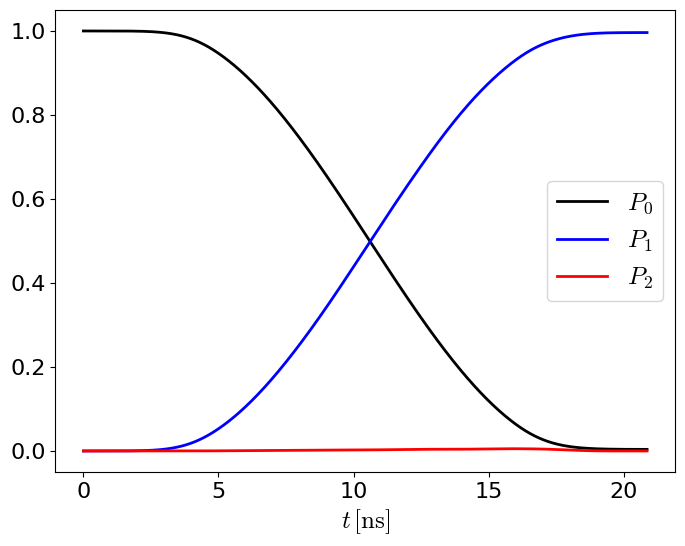

In [19]:
def prob_plot(
    t_list: np.ndarray, 
    probs: np.ndarray, 
    opt: dict={'fs': 18, 'lw': 2.0, 'lw_levels': 3.0, 'ls': 16}
) -> None:
    colors=['black', 'blue', 'red']    
    fig, ax = plt.subplots(figsize=(8, 6))
    for level in range(3):
        ax.plot(t_list, probs[level, :], linewidth=opt['lw'], 
                color=colors[level], label='$P_{}$'.format(str(level)))
    ax.set_xlabel('$t \, [\mathrm{ns}]$', fontsize=opt['fs'])
    ax.tick_params(labelsize=opt['ls'])
    plt.legend(fontsize=opt['fs'])
    plt.show()
    
prob_plot(t_list, probs)      
    
    

Now the previous gate should implement a $Y$ gate on the computational subspace, up to single-qubit phases to be corrected. We now want to obtain the fidelity with respect to this gate.

In [20]:
env_syst = TomoEnv(system=transm, time=2*np.pi*t_list, options=simu_opt, h0_frame=h0_frame)

In [21]:
state_label = ['0', '1']
comp_states = []
for label in state_label:
    comp_states.append(transm.state(label)[1])

In [22]:
# We now perform the tomography
n_process = 4

start = time.time()
sup_op = env_syst.to_super(comp_states, weyl_by_index, n_process)
end = time.time()
print("Computational time = " + str(end - start) + ' s')

Computational time = 4.062800884246826 s


We now need to obtain the single-qubit correction

We have obtained the superoperator associated with the single-qubit correction. We now just need to compute the superoperator associated with the desired $Y$ gate.

In [23]:
y = np.array([[0.0, -1j*1.0], [1j*1.0, 0.0]])
y_sup = trf.kraus_to_super(y, weyl_by_index)

We can now calculate the average process fidelity. 

In [24]:
f_pro = average_process_fidelity(y_sup, sup_op)
display(Latex(r'$F_{{pro}} = {:.5f}$'.format(f_pro)))

<IPython.core.display.Latex object>

In [25]:
avg_leakage = env_syst.leakage(comp_states)
display(Latex(r'$L_1(\mathcal{{E}} ) = {:.7f}$'.format(avg_leakage)))

<IPython.core.display.Latex object>

In [26]:
f_gate = average_gate_fidelity(y_sup, sup_op, avg_leakage)
display(Latex(r'$F_{{gate}} = {:.5f}$'.format(f_gate)))

<IPython.core.display.Latex object>

In what follows we simply rewrite the previous as a function of the pulse as a numpy array

In [31]:
def obj_function(
    pulse_list: np.ndarray
) -> float:
    temperature = 0.020 #K
    thermal_energy = temperature_to_thermalenergy(temperature) # kb T/h in GHz

    levels_t = 3
    transm = SimpleTransmon(
        label='T',
        max_freq=5.0,
        anharm=-0.3,
        diel_loss_tan=0.75*1e-6,
        env_thermal_energy=thermal_energy,
        dim_hilbert=levels_t
    )
    
    freq_drive = 5.0
    h0_frame = freq_drive*transm.basis.num_op
    
    # Setting drive parameters
    rabi_period = 1/generalized_rabi_frequency(['0', '1'], eps_drive, freq_drive, transm)
    t_tot = rabi_period/2 + t_rise #ns (parameters optimized by hand so far) 
    
    # pts_per_drive_period = 10
    nb_points = 1500 # int(t_tot*freq_drive*pts_per_drive_period)
    t_list = np.linspace(0, t_tot, nb_points)
    transm.add_drive(bosonic_drive, label='sq_gate_raise', drive_type='raise', pulse=1j*pulse_list)
    transm.add_drive(bosonic_drive, label='sq_gate_low', drive_type='low', pulse=-1j*pulse_list)
    
    dim = transm.basis.sys_truncated_dims    
    h0_frame_qobj = qutip.qobj.Qobj(
        inpt=h0_frame, dims=[dim, dim], shape=h0_frame.shape, type="oper", isherm=True
    )
    
    simu_opt = qutip.solver.Options()
    simu_opt.atol = 1e-12
    simu_opt.rtol = 1e-10
    
    
    env_syst = TomoEnv(system=transm, time=2*np.pi*t_list, options=simu_opt, h0_frame=h0_frame)
    
    state_label = ['0', '1']
    comp_states = []
    for label in state_label:
        comp_states.append(transm.state(label)[1])
    
    
    # We now perform the tomography
    n_process = 4
    
    start = time.time()

    sup_op = env_syst.to_super(comp_states, weyl_by_index, n_process)
    
    end = time.time()
    print("Tomography time = " + str(end - start) + ' s')
    

    
    y = np.array([[0.0, -1j*1.0], [1j*1.0, 0.0]])
    y_sup = trf.kraus_to_super(y, weyl_by_index)
    
    f_pro = average_process_fidelity(y_sup, sup_op)
    avg_leakage = env_syst.leakage(comp_states)
    f_gate = average_gate_fidelity(y_sup, sup_op, avg_leakage)
    
    return f_gate    

In [32]:
start = time.time()

f_gate_new = obj_function(pulse_list)

end = time.time()
print('Computation time = {:.5f}'.format(end - start) + ' s')
display(Latex(r'$F_{{gate}} = {:.5f}$'.format(f_gate_new)))

Tomography time = 3.8709323406219482 s
Computation time = 3.96864 s


<IPython.core.display.Latex object>